### Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №3 - Дерево решений


**Общая информация**

**Срок сдачи:** 28 мая 2022, 08:30   
**Штраф за опоздание:** по 1 баллу за 24 часа задержки.

При отправлении ДЗ указывайте фамилию в названии файла Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:
[ML0221, Задание 3] Фамилия Имя. 


Используйте данный Ipython Notebook при оформлении домашнего задания.

##  Реализуем дерево решений (3 балла)

Допишите недостающие части дерева решений. Ваша реализация дерева должна работать по точности не хуже DecisionTreeClassifier из sklearn.
Внимание: если Вас не устраивает предложенная структура хранения дерева, Вы без потери баллов можете сделать свой класс DecisionTreeClassifier, в котором сами полностью воспроизведете алгоритм дерева решений. Обязательно в нем иметь только функции fit, predict

In [1]:
from typing import Callable, Union, Tuple
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_wine
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier

In [2]:
def gini(target: np.ndarray) -> float:
    """
    :param target: вектор целевой переменной
    :return gini: критерий Джини
    """
    bins = np.bincount(target)
    p_classes = bins[bins > 0] / len(target)
    return np.sum(p_classes * (1 - p_classes))
    
def entropy(target: np.ndarray) -> float:
    """
    :param target: вектор целевой переменной
    :return entropy: энтропийный критерий
    """
    bins = np.bincount(target)
    p_classes = bins[bins > 0] / len(target)
    return -np.sum(p_classes * np.log(p_classes))

def cls_error(target: np.ndarray) -> float:
    """
    :param target: вектор целевой переменной
    :return cls_error: энтропийный критерий
    """
    bins = np.bincount(target)
    p_classes = bins[bins > 0] / len(target)
    return 1 - np.max(p_classes)

In [3]:
class MyDecisionTreeClassifier:
    NON_LEAF_TYPE = 0
    LEAF_TYPE = 1

    def __init__(self, min_samples_split=2, max_depth=5, criterion='gini'):
        """
        criterion -- критерий расщепления. необходимо релизовать три:
        Ошибка классификации, Индекс Джини, Энтропийный критерий ('gini', 'entropy', 'cls_error')
        max_depth -- максимальная глубина дерева
        min_samples_split -- минимальное число объектов в листе, чтобы сделать новый сплит
        """
        if max_depth < 0:
            raise ValueError(f"Bad max_depth: {max_depth}")
        
        if min_samples_split < 2:
            raise ValueError(f"Bad min_samples_split: {min_samples_split}")
        
        if criterion not in ["gini", "entropy", "cls_error"]:
            raise ValueError(f"Bad criterion: {criterion}")
        
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.num_class = -1

        # Для последнего задания
        self.feature_importances_ = defaultdict(float)
        
        criterions = {
            "gini": gini,
            "entropy": entropy,
            "cls_error": cls_error
        }        
        self.criterion = criterions[criterion]

        # Структура, которая описывает дерево
        # Представляет словарь, где для node_id (айдишник узла дерева) храним
        # (тип_узла, айдишник признака сплита, порог сплита) если тип NON_LEAF_TYPE
        # (тип_узла, предсказание класса, вероятность класса) если тип LEAF_TYPE
        # Подразумевается, что у каждого node_id в дереве 
        # слева узел с айди 2 * node_id + 1, а справа 2 * node_id + 2
        self.tree = dict()

    def __div_samples(self, x, y, feature_id, threshold):
        """
        Разделяет объекты на 2 множества
        x -- матрица объектов
        y -- вектор ответов
        feature_id -- айдишник признака, по которому делаем сплит
        threshold -- порог, по которому делаем сплит
        """
        left_mask = x[:, feature_id] > threshold
        right_mask = ~left_mask
        return x[left_mask], x[right_mask], y[left_mask], y[right_mask]
    
    def __find_threshold(self, sub_x, sub_y) -> Tuple[float, float]:
        """
        Находим оптимальный признак и порог для сплита
        Здесь используемые разные impurity в зависимости от self.criterion
        """
        feature_best, threshold_best, q_value_best = None, None, None
        for feature_id, feature_vector in enumerate(sub_x.transpose()):
            
            # calculating all possible thresholds
            sorted_features = np.sort(np.unique(feature_vector))
            thresholds = (sorted_features[:-1] + sorted_features[1:]) / 2
            
            if len(thresholds) == 0:
                continue

            # calculating quality function on all thresholds
            target_len = len(sub_y)
            criterion_sub_y = self.criterion(sub_y)
            
            q_values = []
            for thres in thresholds:
    
                left_mask = feature_vector > thres
                right_mask = ~left_mask
                target_left, target_right = sub_y[left_mask], sub_y[right_mask] 

                criterion_left = len(target_left) / target_len * self.criterion(target_left)
                criterion_right = len(target_right) / target_len * self.criterion(target_right)
                qual = criterion_sub_y - criterion_left - criterion_right
                    
                q_values.append(qual)

            q_value = np.max(q_values)
            threshold = thresholds[np.argmax(q_values)]
            
            if q_value_best is None or q_value > q_value_best:
                feature_best = feature_id
                q_value_best = q_value
                threshold_best = threshold
        
        self.feature_importances_[feature_best] += q_value_best
        return feature_best, threshold_best

    def __fit_node(self, sub_x, sub_y, node_id, depth):
        """
        Делаем новый узел в дереве
        Решаем, терминальный он или нет
        Если нет, то строим левый узел  с айди 2 * node_id + 1
        И правый узел с айди 2 * node_id + 2
        """
        # критерии останова
        
        # в вершине слишком мало объектов
        if len(sub_y) < 1:
            self.tree[node_id] = (self.LEAF_TYPE, np.random.randint(0, 2), np.random.rand(1))
            return
        
        # все объекты в вершине одного класса
        if np.all(sub_y == sub_y[0]):
            self.tree[node_id] = (self.LEAF_TYPE, sub_y[0], 1.0)
            return
        
        # в вершине слишком мало вершин для деления или превышена максимальная глубина дерева
        if 1 <= len(sub_y) < self.min_samples_split or depth >= self.max_depth:
            best_class = np.argmax(np.bincount(sub_y))
            p_class = np.mean(sub_y == best_class)        
            self.tree[node_id] = (self.LEAF_TYPE, best_class, p_class)
            return
        
        feature_best, threshold_best = self.__find_threshold(sub_x, sub_y)        
        self.tree[node_id] = (self.NON_LEAF_TYPE, feature_best, threshold_best)
        
        x_left, x_right, y_left, y_right = self.__div_samples(sub_x, sub_y, feature_best, threshold_best)
        self.__fit_node(x_left, y_left, 2 * node_id + 1, depth + 1)
        self.__fit_node(x_right, y_right, 2 * node_id + 2, depth + 1)
    
    def fit(self, x, y):
        """
        Рекурсивно строим дерево решений
        Начинаем с корня node_id 0
        """
        self.num_class = np.unique(y).size
        self.__fit_node(x, y, 0, 0) 

    def __predict_class(self, x, node_id):
        """
        Рекурсивно обходим дерево по всем узлам,
        пока не дойдем до терминального
        """
        node = self.tree[node_id]
        if node[0] == self.__class__.NON_LEAF_TYPE:
            _, feature_id, threshold = node
            if x[feature_id] > threshold:
                return self.__predict_class(x, 2 * node_id + 1)
            else:
                return self.__predict_class(x, 2 * node_id + 2)
        else:
            return node[1]
        
    def predict(self, X):
        """
        Вызывает predict для всех объектов из матрицы X
        """
        return np.array([self.__predict_class(x, 0) for x in X])
    
    def fit_predict(self, x_train, y_train, predicted_x):
        self.fit(x_train, y_train)
        return self.predict(predicted_x)
    
    def get_feature_importance(self):
        """
        Возвращает важность признаков
        """
        return self.feature_importances_

In [4]:
my_clf = MyDecisionTreeClassifier(min_samples_split=2)
clf = DecisionTreeClassifier(min_samples_split=2)

In [5]:
wine = load_wine()
X_train, X_test, y_train, y_test = train_test_split(
    wine.data, wine.target, 
    test_size=0.1, stratify=wine.target, 
    random_state=2
)

In [6]:
my_clf.fit(X_train, y_train)
clf.fit(X_train, y_train)

DecisionTreeClassifier()

In [7]:
print(accuracy_score(y_pred=clf.predict(X_test), y_true=y_test))
print(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))

0.9444444444444444
0.9444444444444444


## Ускоряем дерево решений (2 балла)
Добиться скорости работы на fit не медленнее чем в 10 раз sklearn на данных wine. 
Для этого используем numpy.

In [8]:
%time clf.fit(X_train, y_train)

CPU times: user 2.46 ms, sys: 1.85 ms, total: 4.32 ms
Wall time: 2.52 ms


DecisionTreeClassifier()

In [9]:
%time my_clf.fit(X_train, y_train)

CPU times: user 128 ms, sys: 11.4 ms, total: 140 ms
Wall time: 132 ms


## Боевое применение (3 балла)

На практике Вы познакомились с датасетом Speed Dating Data. В нем каждая пара в быстрых свиданиях характеризуется определенным набором признаков. Задача -- предсказать, произойдет ли матч пары (колонка match). 

Пример работы с датасетом можете найти в практике пункт 2
https://github.com/VVVikulin/ml1.sphere/blob/master/2019-09/lecture_06/pract-trees.ipynb

Данные и описания колонок лежат тут
https://cloud.mail.ru/public/8nHV/p6J7wY1y1/speed-dating-experiment/

Скачайте датасет, обработайте данные, как показано на семинаре или своим собственным способом. Обучите дерево классификации. В качестве таргета возьмите колонку 'match'. Постарайтесь хорошо обработать признаки, чтобы выбить максимальную точность. Если точность будет близка к случайному гаданию, задание не будет засчитано. 

In [10]:
def preprocess_spd_data(df):
    df = df.iloc[:, :97]
    
    to_drop = [
        'id', 'idg', 'condtn', 'round', 'position', 'positin1', 'order', 'partner', 
        'age_o', 'race_o', 'pf_o_att', 'pf_o_sin', 'pf_o_int', 'pf_o_fun', 'pf_o_amb', 'pf_o_sha',
        'dec_o', 'attr_o', 'sinc_o', 'intel_o', 'fun_o', 'amb_o', 'shar_o', 'like_o', 'prob_o','met_o',
        'field', 'undergra', 'from', 'zipcode', 'income', 'career', 'sports', 'tvsports', 'exercise', 
        'dining', 'museums', 'art', 'hiking', 'gaming', 'clubbing', 'reading', 'tv', 'theater', 'movies', 
        'concerts', 'music', 'shopping', 'yoga', 'expnum',
        'mn_sat', 'tuition'
    ]

    df = df.drop(to_drop, axis=1)
    df = df.dropna(subset=['age', 'imprelig', 'imprace', 'date'])

    df.loc[:, 'field_cd'] = df.loc[:, 'field_cd'].fillna(19)
    df.loc[:, 'career_c'] = df.loc[:, 'career_c'].fillna(18)
    
    # attr1 processing
    df.loc[:, 'temp_totalsum'] = df.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 
                                            'amb1_1', 'shar1_1']].sum(axis=1)
    df.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']] =\
    (df.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']].T / 
     df.loc[:, 'temp_totalsum'].T).T * 100
    
    # attr2 processing
    df.loc[:, 'temp_totalsum'] = df.loc[:, ['attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 
                                            'amb2_1', 'shar2_1']].sum(axis=1)
    df.loc[:, ['attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']] =\
    (df.loc[:, ['attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']].T / 
     df.loc[:, 'temp_totalsum'].T).T * 100
    df = df.drop(['temp_totalsum'], axis=1)
    
    for i in [4, 5]:
        feat = ['attr{}_1'.format(i), 'sinc{}_1'.format(i), 
                'intel{}_1'.format(i), 'fun{}_1'.format(i), 
                'amb{}_1'.format(i), 'shar{}_1'.format(i)]

        if i != 4:
            feat.remove('shar{}_1'.format(i))
    
        df = df.drop(feat, axis=1)
    
    df = df.drop(['wave'], axis=1)
    df = df.dropna()
    return df

In [11]:
df = pd.read_csv('./data/speed_dating_data.csv', encoding='latin1')

In [12]:
df = preprocess_spd_data(df)

In [13]:
df

,iid,gender,pid,match,int_corr,samerace,age,field_cd,race,imprace,...,sinc2_1,intel2_1,fun2_1,amb2_1,shar2_1,attr3_1,sinc3_1,fun3_1,intel3_1,amb3_1
0,1,0,11.0,0,0.14,0,21.0,1.0,4.0,2.0,...,20.0,15.0,20.0,5.0,5.0,6.0,8.0,8.0,8.0,7.0
1,1,0,12.0,0,0.54,0,21.0,1.0,4.0,2.0,...,20.0,15.0,20.0,5.0,5.0,6.0,8.0,8.0,8.0,7.0
2,1,0,13.0,1,0.16,1,21.0,1.0,4.0,2.0,...,20.0,15.0,20.0,5.0,5.0,6.0,8.0,8.0,8.0,7.0
3,1,0,14.0,1,0.61,0,21.0,1.0,4.0,2.0,...,20.0,15.0,20.0,5.0,5.0,6.0,8.0,8.0,8.0,7.0
4,1,0,15.0,1,0.21,0,21.0,1.0,4.0,2.0,...,20.0,15.0,20.0,5.0,5.0,6.0,8.0,8.0,8.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8373,552,1,526.0,0,0.64,0,25.0,18.0,2.0,1.0,...,0.0,0.0,30.0,0.0,20.0,8.0,7.0,6.0,7.0,7.0
8374,552,1,527.0,0,0.71,0,25.0,18.0,2.0,1.0,...,0.0,0.0,30.0,0.0,20.0,8.0,7.0,6.0,7.0,7.0
8375,552,1,528.0,0,-0.46,0,25.0,18.0,2.0,1.0,...,0.0,0.0,30.0,0.0,20.0,8.0,7.0,6.0,7.0,7.0
8376,552,1,529.0,0,0.62,0,25.0,18.0,2.0,1.0,...,0.0,0.0,30.0,0.0,20.0,8.0,7.0,6.0,7.0,7.0


Разбейте датасет на трейн и валидацию. Подберите на валидации оптимальный критерий  информативности. 
Постройте графики зависимости точности на валидации от глубины дерева, от минимального числа объектов для сплита. 
Какой максимальной точности удалось достигнуть?

In [14]:
x = np.asarray(df.drop(['match'], axis=1))
y = np.asarray(df['match'])
df = df.drop(['match'], axis=1)

In [15]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=1)

## Оптимальный критерий информативности

In [16]:
criterions = ['gini', 'entropy', 'cls_error']
criterions_scores = []
for criterion in criterions:
    clf = MyDecisionTreeClassifier(criterion=criterion)
    clf.fit(x_train, y_train)

    pred = clf.predict(x_test)
    score = accuracy_score(y_test, pred)
    criterions_scores.append(score)

best_criterion = criterions[np.argmax(criterions_scores)]
print(f"Best criterion: {best_criterion}")

Best criterion: gini


## Зависимость точности от глубины дерева

In [17]:
depths = range(2, 10)
depth_scores = []
for depth in depths:
    clf = MyDecisionTreeClassifier(max_depth=depth)
    clf.fit(x_train, y_train)

    pred = clf.predict(x_test)
    score = accuracy_score(y_test, pred)
    depth_scores.append(score)
    
best_max_depth = depths[np.argmax(depth_scores)]
print(f"Best max_depth: {best_max_depth}")

Best max_depth: 4


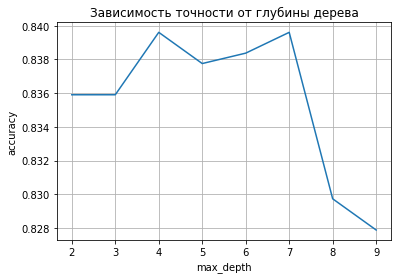

In [18]:
plt.xlabel("max_depth")
plt.ylabel("accuracy")
plt.title("Зависимость точности от глубины дерева")
plt.plot(depths, depth_scores)
plt.grid(True)

## Зависимость точности от минимального числа объектов для сплита

In [19]:
min_samples_splits = [2, 3, 4, 5, 10, 15, 20]
min_samples_scores = []
for min_samples_split in min_samples_splits:
    clf = MyDecisionTreeClassifier(min_samples_split=min_samples_split)
    clf.fit(x_train, y_train)

    pred = clf.predict(x_test)
    score = accuracy_score(y_test, pred)
    min_samples_scores.append(score)

best_min_samples_split = min_samples_splits[np.argmax(min_samples_scores)]
print(f"Best min_samples_split: {best_min_samples_split}")

Best min_samples_split: 2


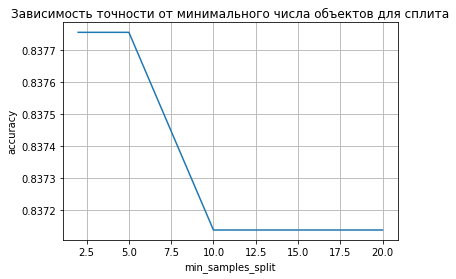

In [20]:
plt.xlabel("min_samples_split")
plt.ylabel("accuracy")
plt.title("Зависимость точности от минимального числа объектов для сплита")
plt.plot(min_samples_splits, min_samples_scores)
plt.grid(True)

## Обучение с найденными параметрами

In [21]:
clf = MyDecisionTreeClassifier(
    criterion=best_criterion,
    max_depth=best_max_depth,
    min_samples_split=best_min_samples_split
)

clf.fit(x_train, y_train)
pred = clf.predict(x_test)
print(f"Best accuracy: {accuracy_score(y_test, pred)}")

Best accuracy: 0.8396051819864281


## Находим самые важные признаки (2 балла)



По построенному дереву  легко понять, какие признаки лучше всего помогли решить задачу. Часто это бывает нужно  не только  для сокращения размерности в данных, но и для лучшего понимания прикладной задачи. Например, Вы хотите понять, какие признаки стоит еще конструировать -- для этого нужно понимать, какие из текущих лучше всего работают в дереве. 

Самый простой метод -- посчитать число сплитов, где использовался данные признак. Это не лучший вариант, так как по признаку который принимает всего 2 значения, но который почти точно разделяет выборку, число сплитов будет очень 1, но при этом признак сам очень хороший. 
В этом задании предлагается для каждого признака считать суммарный gain (в лекции обозначено как Q) при использовании этого признака в сплите. Тогда даже у очень хороших признаков с маленьким число сплитов это значение должно быть довольно высоким.  

Реализовать это довольно просто: создаете словарь номер фичи : суммарный гейн и добавляете в нужную фичу каждый раз, когда используете ее при построении дерева. 

Добавьте функционал, который определяет значения feature importance. Обучите дерево на датасете Speed Dating Data.
Выведите 10 главных фичей по важности.

In [22]:
importances = clf.get_feature_importance()
best_importances = sorted(importances.items(), key=lambda x: -x[1])[:10]

In [23]:
features = [df.columns[feature_id] for feature_id, gain in best_importances]
print("Most important features:", *features, sep=" ")

Most important features: pid sinc3_1 age go_out amb3_1 shar1_1 int_corr field_cd intel2_1 fun3_1


## Фидбек (бесценно)

* Какие аспекты обучения деревьев решений Вам показались непонятными? Какое место стоит дополнительно объяснить?

**Не совсем понятно, как предполагалось ускорить дерево решений с помощью numpy до достаточного (сравнимого с sklearn) времени обучения**

### Ваш ответ здесь

* Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.

### ВАШ ОТЗЫВ ЗДЕСЬ

